In [84]:
import matplotlib.pyplot as plt
from matplotlib import pylab
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.ticker as ticker
from osgeo import gdal
import salem
from salem import *
# from pygeotools.lib import iolib, geolib, timelib, malib, warplib

In [85]:
gl = 0 # number to select glacier
Glacier = ['Kokanee', 'Conrad']
glacier = ['kokanee', 'conrad']
d = 10. #20.  #distance between flux gate points

In [86]:
fl_path = '/home/pelto/Desktop/ice_flux/' + Glacier[gl] + '/'
# gpr_path = '/home/pelto/GIS/GPR/ComparisonData/conrad/'
# vf ='img1_20160417__img1_20170521_vmap_5.0m_35px_spm2/'  # velocity file conrad
vf = 'img1_20160417__img2_20170521_vmap_5m_35px_spm2/' #'img1_20150419__img2_20160417_vmap_5m_35px_spm2/'
vdir = '/home/pelto/Desktop/velocity_mapping/kokanee/' + vf  #Conrad_DEMs/spm2/


path = '/media/pelto/serac_backup/Lidar_DEMs/bare_earth_BC_hydro/kokanee/'
#conrad/'
topo = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/20150912_kokanee_ppp_dem1_clip.tif'

ModuleNotFoundError: No module named 'qgis'

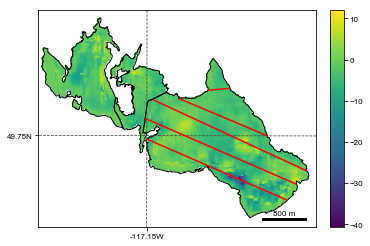

In [87]:
gates = ['Kok_flux_gates.shp' ,'conrad_flux_gates_17.shp']
# points = fl_path + 'conrad_points_17gates_20m_b.shp' #'conrad_points_17gates.shp' ###not being used currently
msk='Kokanee_all_glaciers_2015_ice_msk_5m.tif' #'conrad_2016_ice_msk_5m_glacieronly.tif'
# pts_ras = salem.open_xr_dataset(fl_path + 'FG_17_pts_20m.tif')
# ptsid = salem.open_xr_dataset(fl_path + 'FG_17_ptsid_20m.tif')


# open GeoTIFF as array
#    msk='conrad_2016_ice_msk_5m_glacieronly.tif'
VX = vdir + vf[:-1] + '-F_vx.tif' 
VY = vdir+ vf[:-1] + '-F_vy.tif' 
vx = salem.open_xr_dataset(VX)  #gdal.Open(vx).ReadAsArray()
vy = salem.open_xr_dataset(VY)#gdal.Open(vy).ReadAsArray()
msk = salem.open_xr_dataset(fl_path+ msk) 
msk = msk.to_array(name='msk')

#warplib.memwarp_multi_fn(topo, extent='intersection', res='min', t_srs=vx)
gpr = salem.open_xr_dataset(fl_path + 'Kokanee_gpr_25_100m_5m_outline.tif')
# H_opt = salem.GeoNetcdf(opt_path + 'Conrad101sw_MAE_optimized.nc')
H_opt = salem.open_xr_dataset(fl_path + 'opt_thick_101sw_MAE_utm_5m.tif') #'Conrad101sw_MAE_optimized.nc'
#     pts = salem.read_shapefile(fl_path+pts)
gates = salem.read_shapefile(fl_path+gates[gl])
# msk[msk == 0.0] = 2.0
# msk[msk == 1.0] = np.nan
# pts_ras = pts_ras.to_array()
# ptsid = ptsid.to_array()
vx = vx.to_array(name='vx')
# np.shape(vx[0]) remove index 1 i.e.: 1,2000,3000
vy = vy.to_array(name='vy')
gpr = gpr.to_array(name='gpr')
H_opt = H_opt.to_array(name='H_opt')


dem = salem.open_xr_dataset(topo)
dem_reproj = vx.salem.transform(dem)

dem = dem_reproj.to_array(name='dem')


# ptsid.data[ptsid.data<-1000] = np.nan
# pts_ras.data[pts_ras.data<-1000] = np.nan
gpr.data[gpr.data<0] = np.nan
vx.data = vx.data*msk.data
vx.data = vx.data*msk.data

#     # map extent
# grid = mercator_grid(center_ll=(-116.94, 50.80), extent=(10000, 9000)) ##zoomed out view
grid = vx.salem.grid  ##full view
sm = Map(grid, countries=False)
sm.set_lonlat_contours(interval=0)
sm.set_scale_bar()
sm.set_data(vx)

#      Change the lon-lat countour setting
sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


shpf = '/home/pelto/Desktop/lidar_cbt_analysis/kokanee/Kokanee/kok_all_glaciers_2015_dem.shp' #conrad/Conrad/conrad_all_glaciers_2014.shp'
gdf = salem.read_shapefile(shpf)
sm.set_shapefile(gdf, linewidth=1)
sm.set_shapefile(gates, linewidth=1.5, color='r')
sm.visualize()
plt.show()

In [88]:
H_opt.mean()

<xarray.DataArray 'H_opt' ()>
array(44.72827)

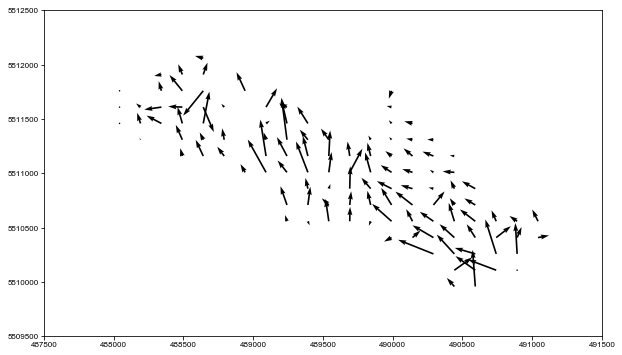

In [89]:
fig, ax = plt.subplots(1,1,figsize=(10,6))


df = salem.read_shapefile(fl_path + 'kokanee_gates_pts_10m_wgs84.shp') #'CPs/kok_gates_pts.shp')

coords = np.array([p.xy for p in df.geometry]).squeeze()
df['lon'] = coords[:, 0]
df['lat'] = coords[:, 1]
# df['lon'] = df[4]
# df['lat'] = df[5]


xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy

ax.scatter(df.lon, df.lat, s=10, c='r' )#c='depth',cmap='viridis', s=10, ax=ax);


X, Y = np.meshgrid(vx.coords['x'],vx.coords['y'])
U = vx.data[0]
V = vy.data[0]

# Q = ax.quiver(X, Y, U, V)#units='width', angles='uv') 
Q = ax.quiver(X[::30, ::30], Y[::30, ::30], U[::30, ::30], V[::30, ::30], units='xy')
ax.set_xlim(487500, 491500)
ax.set_ylim( 5509500, 5512500)
#     plt.quiver(vx.x, vx.y, vx.data ,vy.data)
plt.savefig(fl_path+ 'products/'+ 'kokanee_16_17_quiver.pdf', dpi=300) #'conrad_16_17_quiver.pdf'

In [90]:
# grid = vx.salem.grid  ##full view
# sm = Map(grid, countries=False)
# sm.set_lonlat_contours(interval=0)
# sm.set_scale_bar()
# sm.set_data(vx)

# #      Change the lon-lat countour setting
# sm.set_lonlat_contours(add_ytick_labels=True, interval=0.05, linewidths=0.75, linestyles='--', colors='0.25')


# shpf = '/home/pelto/Desktop/lidar_cbt_analysis/conrad/Conrad/conrad_all_glaciers_2014.shp'
# gdf = salem.read_shapefile(shpf)
# sm.set_shapefile(gdf, linewidth=1)
# sm.set_shapefile(gates, linewidth=1.5, color='r')
# sm.visualize()

In [91]:
vns = ['vx',
       'vy',
       'gpr',
       'H_opt',
       #'msk',
       'dem'
       ]

In [137]:
H_opt

<xarray.DataArray 'H_opt' (variable: 1, y: 524, x: 668)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * x         (x) float64 4.879e+05 4.879e+05 4.879e+05 ... 4.912e+05 4.912e+05
  * y         (y) float64 5.512e+06 5.512e+06 5.512e+06 ... 5.51e+06 5.51e+06
  * variable  (variable) <U4 'data'
Attributes:
    pyproj_srs:  +units=m +init=epsg:32611 

In [92]:
vns

['vx', 'vy', 'gpr', 'H_opt', 'dem']

In [93]:
M = xr.merge([vx,vy,gpr,H_opt,dem])

In [94]:
for vn in vns:
    df[vn] = M[vn][0].interp(x=('z', df.x), y=('z', df.y))

In [95]:
# grid.ij_coordinates
v_crs = check_crs(vx)
# v_crs

In [96]:
df_agg = df[['id', 'len', 'distance', 'angle', 'geometry', 'lon', 'lat']].copy()
ii, jj = grid.transform(df['lon'], df['lat'], crs=salem.wgs84, nearest=True) #
df_agg['i'] = ii
df_agg['j'] = jj
# # We trick by creating an index of similar i's and j's
# df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in (vx.coords['x'], vx.coords['y'])]
df_agg['ij'] = ['{:04d}_{:04d}'.format(i, j) for i, j in zip(ii, jj)]
df_agg = df_agg.groupby('ij').mean()

In [97]:
# Select
for vn in vns:
    df_agg[vn] = M[vn][0].isel(x=('z', df_agg.i), y=('z', df_agg.j))

In [98]:
D = df_agg[['id', 'len', 'distance', 'angle', 'lon', 'lat', 'vx', 'vy', 'gpr', 'H_opt']].copy()
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt
ij,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.470001,64.095955
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,40.470001,64.095955
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.099998,58.278130
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,1.000000,20.840923
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.099998,50.455193
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.099998,50.455193
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,-3.562577,15.348568,34.299999,50.455193


In [99]:
df_agg.to_csv(fl_path+'kok_df_agg.csv')

In [100]:
panda = df_agg.sort_values(by=['gpr'])
panda.gpr.mean()

42.630435943603516

In [101]:
import math
D['vz'] = np.sqrt(D.vx**2 + D.vy**2 )  # np.sqrt(U**2 + V**2 )

D['vzdir'] = np.arcsin(D.vx/D.vz) *180/math.pi #degrees from north


### calculate angle of flux gate
#try making a raster with footprint of vel. raster with FG angle as the value
# FG_alpha = pts_ras.data - 90.0 # calculate normal angle to flux gate 

#multiply velocity vector by cosine of angle between vector and flux gate (line or line segment)
D['vfg'] = np.abs(D.vz * np.cos((D.vzdir-(D.angle-90.))*(math.pi/180.))) #velocity normal to gate per slice
D['Qopt'] = D.vfg * 0.9 * d * D.H_opt     ## ice flux per slice *0.9 to est. depth-integrated velocity
D['a'] = d * D.H_opt #area per slice

In [102]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,vz,vzdir,vfg,Qopt,a
ij,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.470001,64.095955,12.066653,-17.714618,9.077150,5236.277579,640.959549
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,40.470001,64.095955,11.409705,-17.661121,8.589976,4955.244485,640.959549
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.099998,58.278130,11.093633,-15.297392,8.646048,4534.879752,582.781296
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,1.000000,20.840923,2.702985,4.624639,2.557499,479.705684,208.409233
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.099998,50.455193,12.747637,-9.636866,10.674496,4847.253644,504.551926
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926,3.131305,2.256397,2.918355,813.089812,309.569263
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.099998,50.455193,16.584464,-9.778018,13.864966,6296.035605,504.551926
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,3.064546,-19.360383,2.246037,625.773751,309.569263
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,-3.562577,15.348568,34.299999,50.455193,15.756602,-13.067607,12.655042,5746.613389,504.551926


In [103]:
D.vzdir[D.id==0].mean()

-61.339981784697976

In [104]:
Q_out= [0.,] #flux out per gate
cr_area = [0.,] # cross-section area per gate
vzdir = [0.,]

for n in range(D.id.nunique()+1):
        Q_out.append(D.Qopt[D.id==n].sum()) 
        cr_area.append(D.a[D.id==n].sum())
        vzdir.append(D.vzdir[D.id==n].mean())           
Q_in = [Q_out[1:]] #flux in per bin
Q_in = np.squeeze(Q_in)
# Q_in[]



FG = pd.DataFrame(list(zip(Q_out, Q_in, cr_area, vzdir)), columns=['Q_out', 'Q_in', 'cr_area', 'vzdir']) 

FG['vfg'] = FG.Q_out / FG.cr_area #net velocity per gate
FG['bin']=np.arange(0,5,1)
FG

,Q_out,Q_in,cr_area,vzdir,vfg,bin
0,0.000000,10863.008097,0.000000,0.000000,NaN,0
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3
4,288469.973980,0.000000,80350.938377,-34.157650,3.590126,4


### import data per bin: height change, elevation, surface area, obs.SMB etc. 

In [105]:
data = pd.read_csv(fl_path +'kokanee_bins.csv') # 'Conrad_bins_17b.csv'#need dh_dt, area, field pts, n, mid elev (mean elev)
data.sort_values(by=['bin'],ascending=True, inplace=True) # sort by bin
data.set_index('bin', inplace=True) # set bin as index for sorting
data

,area,_count,_sum,dh1516_mean,_median,_stdev,_elevmean,_16_17mean,_16_17medi,17_18mean,17_18media,17_18stdev,17_18mea_1,17_18med_1,17_18std_1,1516vmean,1516vmedia,b_obs16,n_obs16,rho
bin,,,,,,,,,,,,,,,,,,,,
0,63553.001953,63555,-112973.465576,-1.777570,-1.762939,0.775152,2291.147505,-2.065642,-2.101562,-2.005214,-2.145996,0.999086,-1.889405,-2.029297,0.998953,2.534091,2.373828,-0.90,2,910
1,226671.202637,226674,-100047.588379,-0.441372,-0.364502,0.658413,2424.755837,-0.870733,-0.727539,-0.972027,-0.952393,0.785927,-0.849053,-0.829590,0.787406,2.440918,2.119874,0.45,8,850
2,741046.719482,741064,194356.656250,0.262267,0.212158,0.482645,2559.919414,-0.238410,-0.200000,-0.337921,-0.359375,0.462509,-0.210642,-0.232178,0.465280,4.686298,3.663807,0.46,6,575
3,419748.820801,419741,250667.383545,0.597195,0.571045,0.549125,2656.073845,0.028277,-0.145996,-0.217030,-0.207275,0.417545,-0.086929,-0.079834,0.415879,6.113479,4.542166,0.54,6,575
4,336880.583252,336893,231318.983643,0.686624,0.690430,0.671824,2717.695605,-0.244030,-0.400000,-0.214297,-0.241455,0.723609,-0.077272,-0.108154,0.723311,4.968661,3.674392,-2.50,1,910


In [106]:
FG_df =  pd.concat([FG, data], axis=1)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,_count,_sum,dh1516_mean,...,17_18media,17_18stdev,17_18mea_1,17_18med_1,17_18std_1,1516vmean,1516vmedia,b_obs16,n_obs16,rho
0,0.000000,10863.008097,0.000000,0.000000,NaN,0,63553.001953,63555,-112973.465576,-1.777570,...,-2.145996,0.999086,-1.889405,-2.029297,0.998953,2.534091,2.373828,-0.90,2,910
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1,226671.202637,226674,-100047.588379,-0.441372,...,-0.952393,0.785927,-0.849053,-0.829590,0.787406,2.440918,2.119874,0.45,8,850
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2,741046.719482,741064,194356.656250,0.262267,...,-0.359375,0.462509,-0.210642,-0.232178,0.465280,4.686298,3.663807,0.46,6,575
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3,419748.820801,419741,250667.383545,0.597195,...,-0.207275,0.417545,-0.086929,-0.079834,0.415879,6.113479,4.542166,0.54,6,575
4,288469.973980,0.000000,80350.938377,-34.157650,3.590126,4,336880.583252,336893,231318.983643,0.686624,...,-0.241455,0.723609,-0.077272,-0.108154,0.723311,4.968661,3.674392,-2.50,1,910


In [107]:
FG_df['Q_net'] = FG_df.Q_in - FG_df.Q_out  #net flux per gate
FG_df   #[0:4]

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,_count,_sum,dh1516_mean,...,17_18stdev,17_18mea_1,17_18med_1,17_18std_1,1516vmean,1516vmedia,b_obs16,n_obs16,rho,Q_net
0,0.000000,10863.008097,0.000000,0.000000,NaN,0,63553.001953,63555,-112973.465576,-1.777570,...,0.999086,-1.889405,-2.029297,0.998953,2.534091,2.373828,-0.90,2,910,10863.008097
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1,226671.202637,226674,-100047.588379,-0.441372,...,0.785927,-0.849053,-0.829590,0.787406,2.440918,2.119874,0.45,8,850,65112.077007
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2,741046.719482,741064,194356.656250,0.262267,...,0.462509,-0.210642,-0.232178,0.465280,4.686298,3.663807,0.46,6,575,337732.140841
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3,419748.820801,419741,250667.383545,0.597195,...,0.417545,-0.086929,-0.079834,0.415879,6.113479,4.542166,0.54,6,575,-125237.251964
4,288469.973980,0.000000,80350.938377,-34.157650,3.590126,4,336880.583252,336893,231318.983643,0.686624,...,0.723609,-0.077272,-0.108154,0.723311,4.968661,3.674392,-2.50,1,910,-288469.973980


In [108]:
FG_df['Q_netA']= FG_df.Q_net / FG_df.area 
FG_df['b_fg_h'] = FG_df._16_17mean - FG_df.Q_netA  #dh1516_mean
FG_df['b_fg_we'] = FG_df.rho/1000. * FG_df.b_fg_h
FG_df.drop(FG_df.tail(1).index,inplace=True)
FG_df

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,_count,_sum,dh1516_mean,...,17_18std_1,1516vmean,1516vmedia,b_obs16,n_obs16,rho,Q_net,Q_netA,b_fg_h,b_fg_we
0,0.000000,10863.008097,0.000000,0.000000,NaN,0,63553.001953,63555,-112973.465576,-1.777570,...,0.998953,2.534091,2.373828,-0.90,2,910,10863.008097,0.170928,-2.236571,-2.035279
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1,226671.202637,226674,-100047.588379,-0.441372,...,0.787406,2.440918,2.119874,0.45,8,850,65112.077007,0.287253,-1.157986,-0.984288
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2,741046.719482,741064,194356.656250,0.262267,...,0.465280,4.686298,3.663807,0.46,6,575,337732.140841,0.455750,-0.694160,-0.399142
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3,419748.820801,419741,250667.383545,0.597195,...,0.415879,6.113479,4.542166,0.54,6,575,-125237.251964,-0.298362,0.326639,0.187817


In [109]:
D['Agpr']=np.NaN
for n in range(D.id.nunique()+1):

    for c in range(D.id[D.id==n].count()-1):
        idx=D[(D.id==n)&(D.distance==D[D.id==n].distance[c])].index
        
        if c==0:
            G= D.distance[D.id==n][c+1] - D.distance[D.id==n][c] * D.gpr[D.id==n][c+1]*0.5 #area of triangle
        elif c==1:
            G= (D.distance[D.id==n][c+1] - D.distance[D.id==n][c])/2 * D.gpr[D.id==n][c]
        elif c==len(D.id[D.id==n])-2: #
            G= (D.distance[D.id==n][c] - D.distance[D.id==n][c-1])/2 * D.gpr[D.id==n]
        elif c==len(D.id[D.id==n])-1:  #last point in line
            G= D.distance[D.id==n][c] + D.distance[D.id==n][c+1] * D.gpr[D.id==n][c-1]*0.5 #area of triangle
        else:
            G=(((D.distance[D.id==n][c+1]-D.distance[D.id==n][c])/2) + ((D.distance[D.id==n][c] -
                    D.distance[D.id==n][c-1])/2))* D.gpr[D.id==n][c]  
       
        D.loc[idx,'Agpr']= G

#calculate flux out using GPR thicknesses
D['Qo_gpr'] = D.Agpr * D.vfg * 0.9      

In [110]:
D[:8]

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,vz,vzdir,vfg,Qopt,a,Agpr,Qo_gpr
ij,,,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.470001,64.095955,12.066653,-17.714618,9.077150,5236.277579,640.959549,10.000000,81.694353
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,40.470001,64.095955,11.409705,-17.661121,8.589976,4955.244485,640.959549,202.350006,1564.363544
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.099998,58.278130,11.093633,-15.297392,8.646048,4534.879752,582.781296,390.999985,3042.544308
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,1.000000,20.840923,2.702985,4.624639,2.557499,479.705684,208.409233,NaN,NaN
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.099998,50.455193,12.747637,-9.636866,10.674496,4847.253644,504.551926,390.999985,3756.354905
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926,3.131305,2.256397,2.918355,813.089812,309.569263,NaN,NaN
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.099998,50.455193,16.584464,-9.778018,13.864966,6296.035605,504.551926,390.999985,4879.081221
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,3.064546,-19.360383,2.246037,625.773751,309.569263,NaN,NaN


In [111]:
D

,id,len,distance,angle,lon,lat,vx,vy,gpr,H_opt,vz,vzdir,vfg,Qopt,a,Agpr,Qo_gpr
ij,,,,,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,-3.671594,11.494499,40.470001,64.095955,12.066653,-17.714618,9.077150,5236.277579,640.959549,10.000000,81.694353
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,-3.461551,10.871938,40.470001,64.095955,11.409705,-17.661121,8.589976,4955.244485,640.959549,202.350006,1564.363544
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,-2.926824,10.700579,39.099998,58.278130,11.093633,-15.297392,8.646048,4534.879752,582.781296,390.999985,3042.544308
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,0.217935,2.694185,1.000000,20.840923,2.702985,4.624639,2.557499,479.705684,208.409233,NaN,NaN
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,-2.133994,12.567749,39.099998,50.455193,12.747637,-9.636866,10.674496,4847.253644,504.551926,390.999985,3756.354905
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,0.123284,3.128877,NaN,30.956926,3.131305,2.256397,2.918355,813.089812,309.569263,NaN,NaN
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,-2.816563,16.343544,39.099998,50.455193,16.584464,-9.778018,13.864966,6296.035605,504.551926,390.999985,4879.081221
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,-1.015924,2.891252,NaN,30.956926,3.064546,-19.360383,2.246037,625.773751,309.569263,NaN,NaN
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,-3.562577,15.348568,34.299999,50.455193,15.756602,-13.067607,12.655042,5746.613389,504.551926,342.999992,3906.611487


In [112]:
Qo_gpr = [0.,] #flux out per gate
cr_area_gpr = [0.,] # cross-section area per gate
vzdir_gpr = [0.,]
n=0
for n in range(D.id.nunique()):
        Qo_gpr.append(D.Qo_gpr[D.id==n].sum()) 
        cr_area_gpr.append(D.Agpr[D.id==n].sum())
        vzdir_gpr.append(D.vzdir[D.id==n].mean())           
Qin_gpr = [Qo_gpr[1:]] #flux in per bin
Qin_gpr = np.squeeze(Qin_gpr)

In [113]:
Qo_gpr

[0.0,
 11386.909190541564,
 40196.54019017868,
 218463.85580005607,
 67580.44225507314]

In [114]:
FG_gpr = pd.DataFrame(list(zip(Qo_gpr, Qin_gpr, cr_area_gpr)), columns=['Qo_gpr', 'Qin_gpr', 'cr_area_gpr']) 
FG_gpr['bin'] = [0,1,2,3]
# FG_gpr['vfg'] = FG_gpr.Qo_gpr / FG_gpr.cr_area_gpr #net velocity per gate
# FG['bin']=np.arange(0,14,1)
FG_gpr

,Qo_gpr,Qin_gpr,cr_area_gpr,bin
0,0.000000,11386.909191,0.000000,0
1,11386.909191,40196.540190,7503.100033,1
2,40196.540190,218463.855800,21490.200081,2
3,218463.855800,67580.442255,54952.750130,3


In [116]:
FG_all = FG_df.merge(FG_gpr, on='bin')  

In [117]:
FG_all

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,_count,_sum,dh1516_mean,...,b_obs16,n_obs16,rho,Q_net,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr
0,0.000000,10863.008097,0.000000,0.000000,NaN,0,63553.001953,63555,-112973.465576,-1.777570,...,-0.90,2,910,10863.008097,0.170928,-2.236571,-2.035279,0.000000,11386.909191,0.000000
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1,226671.202637,226674,-100047.588379,-0.441372,...,0.45,8,850,65112.077007,0.287253,-1.157986,-0.984288,11386.909191,40196.540190,7503.100033
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2,741046.719482,741064,194356.656250,0.262267,...,0.46,6,575,337732.140841,0.455750,-0.694160,-0.399142,40196.540190,218463.855800,21490.200081
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3,419748.820801,419741,250667.383545,0.597195,...,0.54,6,575,-125237.251964,-0.298362,0.326639,0.187817,218463.855800,67580.442255,54952.750130


In [118]:
FG_all['Q_net_gpr'] = FG_all.Qin_gpr - FG_all.Qo_gpr 
FG_all['Q_netA_gpr']= FG_all.Q_net_gpr / FG_all.area 
FG_all['b_fg_h_gpr'] = FG_all._16_17mean - FG_all.Q_netA_gpr  #dh1516_mean
FG_all['b_fg_we_gpr'] = FG_all.rho/1000. * FG_all.b_fg_h_gpr
# FG_all.drop(FG_all.tail(1).index,inplace=True)
FG_all

,Q_out,Q_in,cr_area,vzdir,vfg,bin,area,_count,_sum,dh1516_mean,...,Q_netA,b_fg_h,b_fg_we,Qo_gpr,Qin_gpr,cr_area_gpr,Q_net_gpr,Q_netA_gpr,b_fg_h_gpr,b_fg_we_gpr
0,0.000000,10863.008097,0.000000,0.000000,NaN,0,63553.001953,63555,-112973.465576,-1.777570,...,0.170928,-2.236571,-2.035279,0.000000,11386.909191,0.000000,11386.909191,0.179172,-2.244814,-2.042781
1,10863.008097,75975.085103,8060.692692,-61.339982,1.347652,1,226671.202637,226674,-100047.588379,-0.441372,...,0.287253,-1.157986,-0.984288,11386.909191,40196.540190,7503.100033,28809.631000,0.127099,-0.997831,-0.848157
2,75975.085103,413707.225944,63513.774967,-42.902520,1.196199,2,741046.719482,741064,194356.656250,0.262267,...,0.455750,-0.694160,-0.399142,40196.540190,218463.855800,21490.200081,178267.315610,0.240562,-0.478971,-0.275408
3,413707.225944,288469.973980,97988.113461,-23.748486,4.222014,3,419748.820801,419741,250667.383545,0.597195,...,-0.298362,0.326639,0.187817,218463.855800,67580.442255,54952.750130,-150883.413545,-0.359461,0.387738,0.222949


In [119]:
# vel_Z_dir.attrs['pyproj_srs'] = vx.attrs['pyproj_srs']

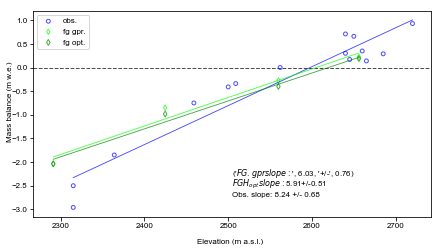

In [120]:
from scipy import stats
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import statsmodels.api as stm


font = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 8}

plt.rc('font', **font)

fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(6,3.34))#3.34, 3.34))
# j,k=0,0    ## only define j if one row
n = 0
s= 15 #markersize
yr = 2017#2016, 2017, 2018
a = 0.7

dt = pd.read_csv('/home/pelto/Desktop/ice_flux/kokanee_b_dot.csv')
##all_obs
x_ax_obs=dt[(dt.Year==yr) & (dt.type=='obs')].Elev
y_ax_obs=dt[(dt.Year==yr) & (dt.type=='obs')].Ba

##obs by bin
# x_ax_obs=FG_df._elevmean  #FG_df.elev_mean
# y_ax_obs=FG_df.b_obs16#b_obs

x_ax_fg_gpr=FG_all._elevmean
y_ax_fg_gpr=FG_all.b_fg_we_gpr

x_ax_fg_opt=FG_df._elevmean   #FG_df.elev_mean
y_ax_fg_opt=FG_df.b_fg_we

### observations of SMB
slope, intercept, r_value, p_value, std_err = stats.linregress(np.array(x_ax_obs),np.array(y_ax_obs))
ax.scatter(x_ax_obs,y_ax_obs,color='b', label='obs.', alpha=a, s=s,facecolor='')
ax.plot(x_ax_obs,slope*x_ax_obs+intercept, color='b',label='', alpha=a, linewidth=0.9)

slopeG, interceptG, r_valueG, p_valueG, std_errG = stats.linregress(np.array(x_ax_fg_gpr),np.array(y_ax_fg_gpr))
ax.scatter(x_ax_fg_gpr,y_ax_fg_gpr,color='lime', label='fg gpr.', alpha=a, s=s,facecolor='', marker='d')
ax.plot(x_ax_fg_gpr,slopeG*x_ax_fg_gpr+interceptG, color='lime',label='', alpha=a, linewidth=0.9)

# X = [x_ax_obs, x_ax_fg_gpr, x_ax_fg_opt]
# Y = [y_ax_obs, y_ax_fg_gpr, y_ax_fg_opt]
# out=[]
# for i in range(3):
#      ## X usually means our input variables (or independent variables)
#      ## Y usually means our output/dependent variable
#     X_new = stm.add_constant(X[i]) ## let's add an intercept (beta_0) to our model
#     mod = stm.OLS(Y[i], X_new).fit()   #FG_all.b_fg_we_gpr, FG_all._elevmean) # stm.OLS(output, input)
#     predictions = mod.predict(X_new)
#     out.append(np.round(1000*mod.bse[1],2) )





#         ### flux gate from GPR thickness
#         slopeM, interceptM, r_valueM, p_valueM, std_errM = stats.linregress(np.array(x_ax_fg),np.array(y_ax_fg))
#         ax.scatter(x_ax_fg,y_ax_fg,color='r', label='fgel', alpha=a, s=s+2, facecolor='')
#         ax.plot(x_ax_fg,slopeM*x_ax_fg+interceptM, color='r', label='', alpha=a, linewidth=0.9)
#         ax.text(0.5, 0.1, ['$obs. slope:$', np.round(slope,4)], transform=ax.transAxes)
#         ax.text(0.5, 0.2, ['$FG. slope:$', np.round(slopeM,4)], transform=ax.transAxes)

#         ax.text(0.05, 0.9, year[n], transform=ax.transAxes, fontweight='bold')

###flux gate from optimized thickness
slopeM_opt, interceptM_opt, r_valueM_opt, p_valueM_opt, std_errM_opt = stats.linregress(np.array(
    x_ax_fg_opt),np.array(y_ax_fg_opt))
ax.scatter(x_ax_fg_opt,y_ax_fg_opt,color='g', label='fg opt.', alpha=a, s=s+2, facecolor='', marker='d')
ax.plot(x_ax_fg_opt,slopeM_opt*x_ax_fg_opt+interceptM_opt, color='g', label='', alpha=a, linewidth=0.9)
ax.axhline(linewidth=1, color='k', ls='--', alpha=a, zorder=0)

# ax.text(0.05, 0.9, 'All', transform=ax.transAxes, fontweight='bold')
txt='Obs. slope: ' + str(np.round(1000*slope,2))+ ' +/- ' + str(np.round(1000*std_err,2))
# txtO=
# txtG=
ax.text(0.5, 0.1, txt, transform=ax.transAxes)
ax.text(0.5, 0.15, (str('$FG ' + 'H_{opt}''slope:$')+ str(np.round(1000*slopeM_opt,2))+ '+/-' + str(np.round(1000*std_errM_opt,2))), transform=ax.transAxes)
ax.text(0.5, 0.2, ('$FG. gpr slope:$', np.round(1000*slopeG,2),'+/-', np.round(1000*std_errG,2)), transform=ax.transAxes)
#'$\frac{+}{-}$'

fig.subplots_adjust(bottom=0.12, top=0.98, hspace=0.1, left=0.07, right=0.99, wspace=0.05)#left=0.07, right=0.9,wspace=0.05, 
ax.legend(loc='best')#, bbox_to_anchor=(0, 0.42, 0.7, 0.5), labelspacing=0.2, handletextpad=0.1)
fig.text(0.01, 0.75, 'Mass balance (m w.e.)', rotation=90)
fig.text(0.45, 0.01, 'Elevation (m a.s.l.)')
plt.savefig(fl_path + 'products/' + Glacier[gl]+ '_bdot_2017.png', dpi=300)
plt.show()

In [121]:
txt=(str('$FG ' + '$H_{opt}$'+'slope:$')+ str(np.round(1000*slopeM_opt,2))+ '+/-' + str(np.round(1000*std_errM_opt,2)))
txt

'$FG $H_{opt}$slope:$5.91+/-0.51'

In [122]:
X = x_ax_obs ## X usually means our input variables (or independent variables)
Y = y_ax_obs ## Y usually means our output/dependent variable
X = stm.add_constant(X) ## let's add an intercept (beta_0) to our model
mod = stm.OLS(Y, X).fit()   #FG_all.b_fg_we_gpr, FG_all._elevmean) # stm.OLS(output, input)
predictions = mod.predict(X)



/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [123]:
# res=mod.fit()

In [124]:
#Linear models with independently and identically distributed errors, estimation by ordinary least squares (OLS)
#https://www.statsmodels.org/stable/regression.html#examples
# Print out the statistics
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:                     Ba   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.912
Method:                 Least Squares   F-statistic:                     145.7
Date:                Fri, 17 Jan 2020   Prob (F-statistic):           1.95e-08
Time:                        17:45:50   Log-Likelihood:                -4.5213
No. Observations:                  15   AIC:                             13.04
Df Residuals:                      13   BIC:                             14.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.4025      1.747    -12.253      0.0

/home/pelto/anaconda2/envs/oggm_env/lib/python3.6/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


In [125]:
# https://www.statsmodels.org/dev/generated/statsmodels.regression.linear_model.RegressionResults.html
print('Parameters:', mod.params)
print('R2: ', mod.rsquared)
SE=mod.bse                              #res.ssr
SE


Parameters: const   -21.402462
Elev      0.008239
dtype: float64
R2:  0.9180602591897757


const    1.746690
Elev     0.000683
dtype: float64

In [126]:
# print('Slope fg Hgpr:', )
print('Slope obs.:', np.round(1000*mod.params[1],2), '+/-', np.round(1000*mod.bse[1],2) )

Slope obs.: 8.24 +/- 0.68


In [127]:
df_agg

,id,len,distance,angle,lon,lat,i,j,vx,vy,gpr,H_opt,dem
ij,,,,,,,,,,,,,
0257_0261,2,1986,0.0,113.499646,-117.150273,49.751861,257,261,-3.671594,11.494499,40.470001,64.095955,2690.673340
0258_0262,2,1986,10.0,113.499646,-117.150146,49.751826,258,262,-3.461551,10.871938,40.470001,64.095955,2690.420898
0260_0263,2,1986,20.0,113.499646,-117.150018,49.751790,260,263,-2.926824,10.700579,39.099998,58.278130,2687.506104
0260_0311,3,1847,0.0,113.508674,-117.150000,49.749626,260,311,0.217935,2.694185,1.000000,20.840923,2686.508301
0262_0263,2,1986,30.0,113.499646,-117.149891,49.751754,262,263,-2.133994,12.567749,39.099998,50.455193,2683.484375
0262_0312,3,1847,10.0,113.508674,-117.149873,49.749590,262,312,0.123284,3.128877,NaN,30.956926,2682.486816
0264_0264,2,1986,40.0,113.499646,-117.149764,49.751719,264,264,-2.816563,16.343544,39.099998,50.455193,2679.908936
0264_0312,3,1847,20.0,113.508674,-117.149745,49.749554,264,312,-1.015924,2.891252,NaN,30.956926,2679.775879
0266_0265,2,1986,50.0,113.499646,-117.149636,49.751683,266,265,-3.562577,15.348568,34.299999,50.455193,2676.887695


No handles with labels found to put in legend.


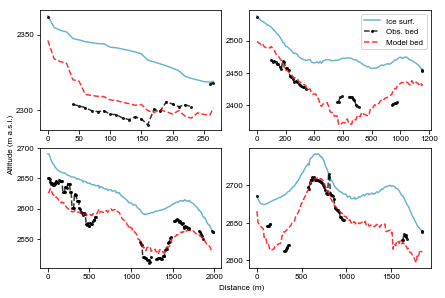

In [135]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)
pylab.rcParams['xtick.major.pad']='2'
pylab.rcParams['ytick.major.pad']='2'

j,k = 0,0
n=0
# df_agg['area_opt'] = df_agg.thick_opt * 10 
a=0.8
letter='a','b','c','d'

fig, ax = plt.subplots(2,2)
for i in range(4):
    
    # plot glacier surface
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem), color='#43a2ca', alpha=a, label='Ice surf.')
    
    #plot gpr thickness gates
    gpr=(df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].gpr)
    gpr_mask=np.isfinite(gpr)
    ax[j,k].plot(df_agg[df_agg.id==i].distance, gpr, marker='o'
                 , ms=2, ls='--', color='k', alpha=a, label='Obs. bed')
    
#         ax[j,k].set_ylim(((df_agg.elev[df_agg.id_opt==i])-(df_agg[df_agg.id_opt==i].thick_opt)+5).max(), -5)
    
    ##plot optimized thickness gates
    ax[j,k].plot(df_agg[df_agg.id==i].distance, (df_agg[df_agg.id==i].dem)-(df_agg[df_agg.id==i].H_opt), 
                 ls='--', c='r', alpha=a, label='Model bed')  #marker='o')
    
    ax[j,k].yaxis.set_major_locator(ticker.MultipleLocator(50)) ##
#     ax[j,k].text(0.05, 0.05, letter[i], transform=ax[j,k].transAxes, fontweight='bold', fontsize=10, verticalalignment='center', horizontalalignment='center',)
    n += 1

    k += 1
    if n == 2: 
        j += 1
        k = 0  
         
    ax[0,1].legend()
      
fig.text(0.01, 0.6, 'Altitude (m a.s.l.)', rotation=90)
fig.text(0.5, 0.01, 'Distance (m)')     
fig.subplots_adjust(bottom=0.085, top=0.98, left=0.085, right=0.99, wspace=0.15, hspace=0.15) 
plt.savefig('/home/pelto/Desktop/ice_flux/Kokanee/products/Kokanee_flux_gates_new.png', dpi=300)
plt.show()

# for i in range(4):
#     area=df_agg[df_agg.id_opt==i].area_opt
#     area_total = area.sum()
#     print(area_total)        